# Deep Convolutional Generative Adversarial Network

## Imports

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import time
from datetime import timedelta
import imageio
import PIL

from IPython import display

TensorFlow 2.x selected.


## Load the Dataset

We have used the MNIST Handwritten digits dataset.

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Preprocessing

In this pahse we have only rehaped the input data and normalized the data to bring it in the range [-1, 1].

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

## Use *tf.data* to create batches and shuffle the dataset

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Models

Here is the class that holds the models and also provides some of the important functionalities associated for savingand loading the models.

In [0]:
class DCGAN(tf.keras.Model):
  def __init__(self, noise_dim):
    super(DCGAN, self).__init__()
    self.noise_dim = noise_dim
    self.generator = tf.keras.Sequential(
      [
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(self.noise_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((7, 7, 256)),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(1, (5, 5), (2, 2), padding='same', use_bias=False, activation=tf.nn.tanh),
      ], name='Generator'
    )

    self.discriminator = tf.keras.Sequential(
      [
        tf.keras.layers.Conv2D(64, (5, 5), (2, 2), input_shape=(28, 28, 1), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (5, 5), (2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1),
      ], name='Discriminator'
    )

  def save(self, fname=None):
    if fname:
      self.discriminator.save_weights(f'{fname}-discriminator-weights.h5')
      self.generator.save_weights(f'{fname}-generator-weights.h5')
    else:
      self.discriminator.save_weights('dcgan-discriminator-weights.h5')
      self.generator.save_weights('dcgan-generator-weights.h5')
  
  def load(self, fname=None):
    if fname:
      self.discriminator.load_weights(f'{fname}-discriminator-weights.h5')
      self.generator.load_weights(f'{fname}-generator-weights.h5')
    else:
      self.discriminator.load_weights('dcgan-discriminator-weights.h5')
      self.generator.load_weights('dcgan-generator-weights.h5')

## Loss Function and Optimizer

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

## Parameters for training and the CVAE Object

### Parameters:

- *epochs*: Number of epochs for training
- *noise_dim*: Dimentionality of the Noise Space
- *num_examples_to_generate*: Number of samples to be generated during the training and testing process
- *seed*: Seed for Image Generation during Training
- *model*: DCGAN Model object.

In [0]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
model = DCGAN(noise_dim)

## Model Summaries

In [9]:
model.generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0 

In [10]:
model.discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

### Function to Generate and Save Images

In [0]:
def generate_and_save_images(model, epoch, test_input, save_img=False, folder='images'):
  if not os.path.exists(folder):
    os.mkdir(folder)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if save_img:
    plt.savefig(f'{folder}/{folder}_{epoch:04d}.png')
  plt.show()

### Training Block

In [0]:
@tf.function
def train_step(model, images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = model.generator(noise, training=True)

      real_output = model.discriminator(images, training=True)
      fake_output = model.discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, model.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, model.discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, model.generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model.discriminator.trainable_variables))

    return gen_loss, disc_loss

In [0]:
def train(dataset, epochs):
  generate_and_save_images(model.generator, 0, seed, save_img=True)
  
  gen_losses = []
  disc_losses = []
  start_training = time.perf_counter()

  for epoch in range(1, epochs + 1):
    gen_loss = tf.keras.metrics.Mean()
    disc_loss = tf.keras.metrics.Mean()

    start = time.perf_counter()
    for image_batch in dataset:
      gl, dl = train_step(model, image_batch)
      gen_loss(gl)
      disc_loss(dl)
    elapsed = time.perf_counter() - start

    gen_losses.append(gen_loss.result())
    disc_losses.append(disc_loss.result())

    display.clear_output(wait=True)
    print (f'ETA: {timedelta(seconds=int(elapsed * (epochs - epoch)))}\tEpoch: {epoch}/{epochs}\tGenerator Loss: {gen_losses[-1]:.4f}\tDiscriminator Loss: {disc_losses[-1]:.4f}')
    generate_and_save_images(model.generator, epoch, seed, epoch % 5 == 0)

  training_time = time.perf_counter() - start_training

  return gen_losses, disc_losses, training_time

ETA: 0:00:00	Epoch: 500/500	Generator Loss: 0.8893	Discriminator Loss: 1.2821


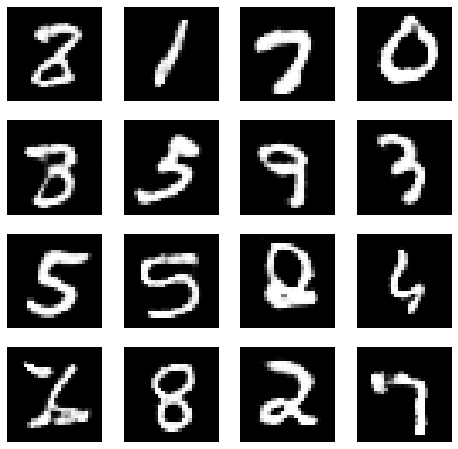

In [14]:
gen_losses, disc_losses, training_time = train(train_dataset, EPOCHS)

In [15]:
print(f'Training Time: {timedelta(seconds=int(training_time))}')

Training Time: 0:59:42


## Losses

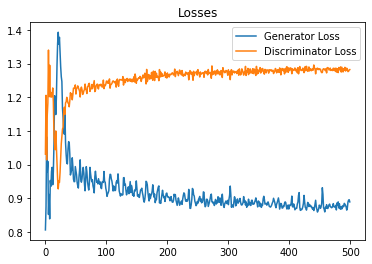

In [16]:
plt.plot(list(range(len(gen_losses))), gen_losses, label='Generator Loss')
plt.plot(list(range(len(disc_losses))), disc_losses, label='Discriminator Loss')
plt.title('Losses')
plt.legend()

plt.savefig('dcgan-losses.png')
plt.show()

## Samples And Benchmark Predictions

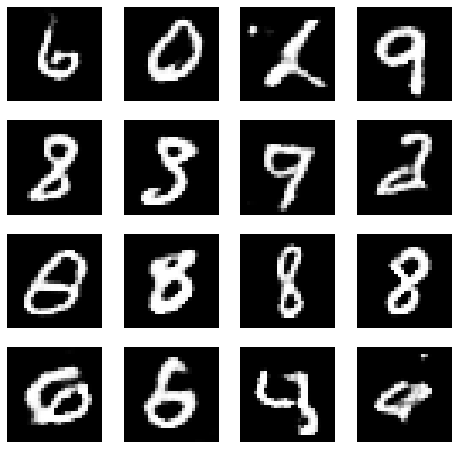

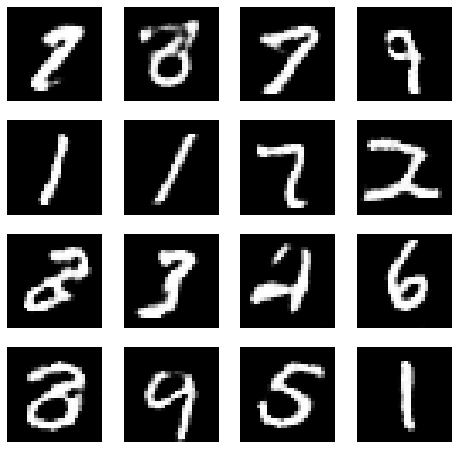

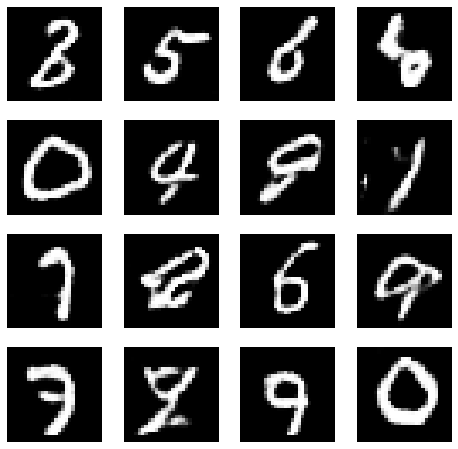

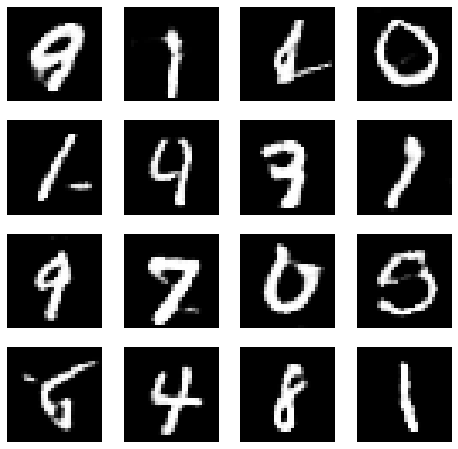

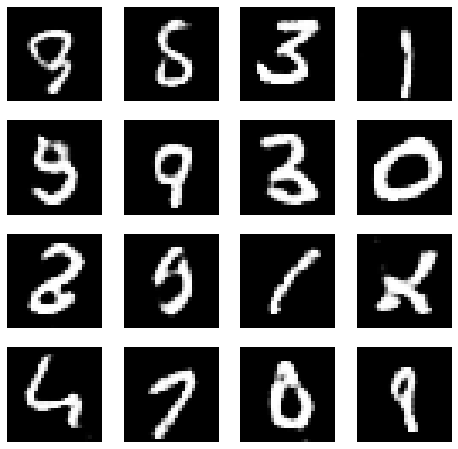

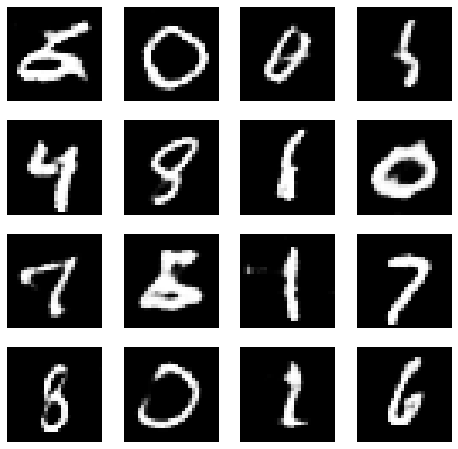

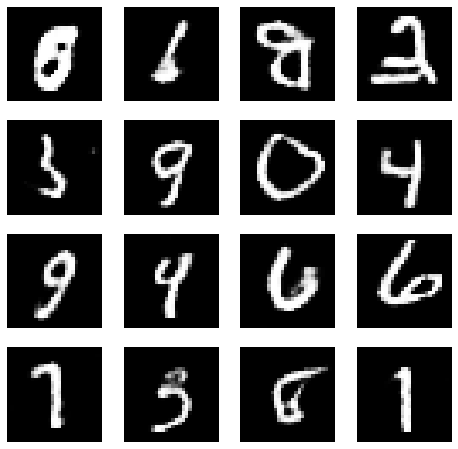

In [33]:
num_seed_sets = 7
seeds = tf.random.normal(shape=[num_seed_sets, num_examples_to_generate, noise_dim])
for i in range(num_seed_sets):
  generate_and_save_images(model.generator, i, seeds[i], save_img=True, folder='samples')
seeds = seeds.numpy().reshape(-1, noise_dim)

In [34]:
samples = (model.generator.predict(seeds) + 1) / 2

benchmark_model = tf.keras.models.load_model('mnist-benchmark.h5')
predictions = benchmark_model.predict_classes(samples)

print('Predictions for above generated imagrs:\n')
print(predictions.reshape(num_seed_sets, 4, 4))

Predictions for above generated imagrs:

[[[6 0 1 9]
  [8 3 9 2]
  [0 8 8 8]
  [6 6 4 6]]

 [[7 6 7 9]
  [1 1 7 2]
  [2 3 2 6]
  [3 9 5 1]]

 [[3 5 6 6]
  [0 4 9 1]
  [7 8 6 9]
  [3 9 9 0]]

 [[9 1 6 0]
  [1 4 7 1]
  [9 7 0 5]
  [5 4 8 1]]

 [[9 5 3 1]
  [5 9 3 0]
  [2 5 1 2]
  [4 7 0 9]]

 [[5 0 0 5]
  [4 8 1 0]
  [7 5 1 7]
  [5 0 1 6]]

 [[8 6 8 2]
  [5 9 0 4]
  [9 4 6 6]
  [1 5 8 1]]]


## Benchmark Model Summary

In [30]:
benchmark_model.summary()

Model: "MNIST_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 8)           6408      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               